# Introdução

Este notebook tem como objetivo responder duas questões chaves do case técnico:

1. Análise do grau de substituição dos SKUs em ruptura pelos itens similares recomendados pelo modelo. 
2. Estimativa de vendas esperadas dos SKUs em ruptura, caso tais rupturas não tivessem ocorrido. 

# Metodologia

Irei explorar e pré-processar os dados fornecidos, preparando-os para que possam ser manipulados com o objetivo de responder às questões propostas.
Para a questão 1, será criada uma taxa de substituição, que consiste em identificar o momento da ruptura de estoque do produto na loja onde ele se encontra e, a partir disso, calcular o incremento nas vendas do item sugerido pelo modelo de recomendação. Esse incremento será obtido com base na média móvel dos últimos 30 dias.
Com o incremento em mãos, também será calculada a média móvel dos últimos 30 dias do item em falta, permitindo assim o cálculo da taxa de substituição.

A fórmula utilizada será:
Taxa de substituição = incremento / média móvel dos últimos 30 dias do item em falta

Para o Item 2, serão testados diferentes modelos preditivos com o objetivo de estimar as vendas que ocorreriam caso não houvesse ruptura de estoque. A seleção do melhor modelo será feita com base na métrica MAE (Erro Absoluto Médio), por sua interpretabilidade e adequação a problemas de regressão.
Para capturar comportamentos de tendência e sazonalidade, serão criadas variáveis de defasagem (lags). Além disso, será construído um conjunto de variáveis diferenciais do tipo delta_x = quantidade_vendida - lag_x, com o intuito de identificar variações abruptas entre períodos consecutivos.
A validação dos modelos será feita por meio de validação cruzada aninhada (nested cross-validation), que permite uma avaliação mais robusta e imparcial do desempenho em problemas com risco de overfitting. Para análise de explicabilidade dos modelos, será utilizado o método SHAP, permitindo compreender a contribuição de cada variável na predição.

# Abordagem/Desenvolvimento

## Importação das bibliotecas

In [364]:
import pandas as pd
import numpy as np

In [365]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import shap

## Tratamento dos dados e criação de algumas features

In [392]:
df_estoques = pd.read_csv('../data/tb_estoques.csv')
df_estoques.head()

,key_loja,cod_produto,dt_estoque,qt_estoque
0,1,1428,2024-03-18,108
1,1,1428,2024-12-13,24
2,1,1428,2024-07-30,33
3,1,1428,2024-07-22,34
4,1,1428,2024-07-29,34


Identificando nulos

In [393]:
df_estoques.isnull().sum()

key_loja       0
cod_produto    0
dt_estoque     0
qt_estoque     0
dtype: int64

Verificar e alterar tipagens

In [394]:
df_estoques.dtypes

key_loja        int64
cod_produto     int64
dt_estoque     object
qt_estoque      int64
dtype: object

In [395]:
df_estoques['dt_estoque'] = pd.to_datetime(df_estoques['dt_estoque'])
df_estoques.dtypes

key_loja                int64
cod_produto             int64
dt_estoque     datetime64[ns]
qt_estoque              int64
dtype: object

Criação da coluna ruptura, para identificar momentos em que houve ruptura do estoque

In [396]:
df_estoques = df_estoques.sort_values(['key_loja','cod_produto','dt_estoque'])
df_estoques['ruptura'] = df_estoques['qt_estoque'].apply(lambda x: 1 if x==0 else 0)
df_estoques.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,ruptura
46,1,1428,2024-01-01,108,0
114,1,1428,2024-01-02,108,0
9,1,1428,2024-01-03,108,0
358,1,1428,2024-01-04,108,0
266,1,1428,2024-01-05,108,0


In [397]:
df_similares = pd.read_csv('../data/tb_similares.csv')
df_similares.head()

,cod_material,cod_material_recom,ranking
0,48635,25472,1
1,50651,74932,1
2,48062,77684,1
3,49893,48730,1
4,49943,84203,1


Identificando nulos

In [398]:
df_similares.isnull().sum()

cod_material          0
cod_material_recom    0
ranking               0
dtype: int64

In [399]:
df_similares.isna().sum()

cod_material          0
cod_material_recom    0
ranking               0
dtype: int64

identificando algumas métricas estatísticas, principalmente no ranking, podemos identificar que para cada produto temos até 3 recomendações

In [400]:
df_similares.describe()

,cod_material,cod_material_recom,ranking
count,110.000000,110.000000,110.000000
mean,49808.772727,56650.909091,1.927273
std,15570.990743,20196.551436,0.809452
min,1428.000000,1428.000000,1.000000
25%,48562.000000,48672.250000,1.000000
50%,49881.000000,49945.000000,2.000000
75%,51349.500000,76665.500000,3.000000
max,84068.000000,93024.000000,3.000000


In [401]:
df_similares.dtypes

cod_material          int64
cod_material_recom    int64
ranking               int64
dtype: object

In [402]:
df_vendas = pd.read_csv('../data/tb_vendas.csv')
df_vendas.head()

,dt_venda,cod_pedido,canal,des_estado_franquia,key_loja,cod_material,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado,vlr_desconto
0,2024-05-10,386761455,FISCO,SP,1,1428,217.0,422944,731659,248.7,0.00
1,2024-03-25,377623716,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,88.23
2,2024-03-19,376372149,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,88.23
3,2024-10-23,414882456,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,0.00
4,2024-02-27,371457908,DIGITAL,SP,1,1428,217.0,422944,731659,230.7,0.00


Identificando nulos

In [403]:
df_vendas.isnull().sum()

dt_venda                   0
cod_pedido                 0
canal                      0
des_estado_franquia        0
key_loja                   0
cod_material               0
categoria_produto         34
sub_categoria_produto      0
linha_produto              0
vlr_venda_tabelado         0
vlr_desconto             270
dtype: int64

Verificar e alterar tipagens

In [404]:
df_vendas.dtypes

dt_venda                  object
cod_pedido                 int64
canal                     object
des_estado_franquia       object
key_loja                   int64
cod_material               int64
categoria_produto        float64
sub_categoria_produto      int64
linha_produto              int64
vlr_venda_tabelado       float64
vlr_desconto             float64
dtype: object

para casos nulos estou inserindo 0 para indicar, neste caso, que não há categoria e nem descontos

In [405]:
df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'])
df_vendas['categoria_produto'] = df_vendas['categoria_produto'].fillna(0).astype(int)
df_vendas['vlr_desconto'] = df_vendas['vlr_desconto'].fillna(0)
df_vendas.dtypes

dt_venda                 datetime64[ns]
cod_pedido                        int64
canal                            object
des_estado_franquia              object
key_loja                          int64
cod_material                      int64
categoria_produto                 int32
sub_categoria_produto             int64
linha_produto                     int64
vlr_venda_tabelado              float64
vlr_desconto                    float64
dtype: object

Identificando nulos após transformações

In [406]:
df_vendas.isnull().sum()

dt_venda                 0
cod_pedido               0
canal                    0
des_estado_franquia      0
key_loja                 0
cod_material             0
categoria_produto        0
sub_categoria_produto    0
linha_produto            0
vlr_venda_tabelado       0
vlr_desconto             0
dtype: int64

## 1.  Análise do grau de substituição dos SKUs em ruptura pelos itens similares recomendados pelo modelo.

Identificando somente os itens em que tivemos a ruptura

In [381]:
df_estoques_ruptura = df_estoques.copy()
df_estoques_ruptura = df_estoques_ruptura[df_estoques_ruptura['ruptura'] == 1]
df_estoques_ruptura.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,ruptura
92,1,1428,2024-11-19,0,1
243,1,1428,2024-11-20,0,1
323,1,1428,2024-11-21,0,1
247,1,1428,2024-11-22,0,1
1217,1,22230,2024-01-01,0,1


Renomeando algumas colunas e ordenando o dataframe

In [382]:
df_similares = df_similares.sort_values(['cod_material','ranking'])
df_similares = df_similares.rename(columns={'cod_material': 'cod_produto', 'cod_material_recom': 'cod_produto_recom'})
df_similares.head()

,cod_produto,cod_produto_recom,ranking
32,1428,1650,1
77,1428,1640,2
98,1428,48282,3
30,1650,1428,1
54,1650,1640,2


identifiquei que há itens em que não há itens com estoque em ruptura que não há itens similares, então a analise que é a respeito do grau de substiuição pelos itens similares, sobre itens que tiveram uma ruptura, foi retirado estes itens.

In [383]:
df_estoques_ruptura = df_estoques_ruptura.merge(df_similares, on='cod_produto', how='left')
numero_de_linhas = len(df_estoques_ruptura)
print(f'O DataFrame tem {numero_de_linhas} linhas.')

O DataFrame tem 125695 linhas.


In [384]:
df_estoques_ruptura = df_estoques_ruptura[df_estoques_ruptura['cod_produto_recom'].notna()]
numero_de_linhas = len(df_estoques_ruptura)
print(f'O DataFrame tem {numero_de_linhas} linhas.')

O DataFrame tem 56559 linhas.


In [385]:
df_estoques_ruptura.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,ruptura,cod_produto_recom,ranking
0,1,1428,2024-11-19,0,1,1650.0,1.0
1,1,1428,2024-11-19,0,1,1640.0,2.0
2,1,1428,2024-11-19,0,1,48282.0,3.0
3,1,1428,2024-11-20,0,1,1650.0,1.0
4,1,1428,2024-11-20,0,1,1640.0,2.0


Nesta etapa, serão criadas novas features e os dados serão transformados com o objetivo de calcular médias móveis, que servirão de base para o cálculo do incremento e, posteriormente, da taxa de substituição.
Utilizei uma janela de 30 dias para a média móvel, com o intuito de suavizar picos de vendas atípicos, como os provocados por queimas de estoque ou promoções agressivas.

In [386]:
df_vendas.head()

,dt_venda,cod_pedido,canal,des_estado_franquia,key_loja,cod_material,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado,vlr_desconto
0,2024-05-10,386761455,FISCO,SP,1,1428,217,422944,731659,248.7,0.00
1,2024-03-25,377623716,DIGITAL,SP,1,1428,217,422944,731659,248.7,88.23
2,2024-03-19,376372149,DIGITAL,SP,1,1428,217,422944,731659,248.7,88.23
3,2024-10-23,414882456,DIGITAL,SP,1,1428,217,422944,731659,248.7,0.00
4,2024-02-27,371457908,DIGITAL,SP,1,1428,217,422944,731659,230.7,0.00


In [387]:
def aplicar_rolling(grupo):
    grupo = grupo.set_index('dt_venda').sort_index()
    grupo['media_movel_30d_qt_total_vendido'] = grupo['qt_total_vendido'].rolling('30D').mean()
    return grupo.reset_index()

In [388]:
df_vendas_select = df_vendas.sort_values(['key_loja','dt_venda','cod_material']).copy()

df_vendas_select = df_vendas_select[['key_loja','dt_venda','cod_material','vlr_venda_tabelado','vlr_desconto']]
df_vendas_select['desconto_aplicado'] = df_vendas_select['vlr_desconto'].apply(lambda x: 1 if x > 0 else 0)
df_vendas_agg = df_vendas_select.groupby(['key_loja','dt_venda','cod_material']).agg(qt_total_vendido=('cod_material', 'count'), total_de_desconto_aplicado=('desconto_aplicado', 'sum')).reset_index()

df_vendas_agg = df_vendas_agg.rename(columns={'cod_material': 'cod_produto'})
df_vendas_agg = df_vendas_agg.sort_values(['key_loja', 'cod_produto', 'dt_venda'])

df_vendas_agg = df_vendas_agg.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(aplicar_rolling)


df_vendas_agg

C:\Users\MAX\AppData\Local\Temp\ipykernel_12088\2190908871.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_vendas_agg = df_vendas_agg.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(aplicar_rolling)


,dt_venda,key_loja,cod_produto,qt_total_vendido,total_de_desconto_aplicado,media_movel_30d_qt_total_vendido
0,2024-01-05,1,1428,2,2,2.000000
1,2024-01-08,1,1428,1,1,1.500000
2,2024-01-15,1,1428,2,2,1.666667
3,2024-01-16,1,1428,1,1,1.500000
4,2024-01-17,1,1428,1,1,1.400000
...,...,...,...,...,...,...
101,2024-09-16,8,84206,2,0,1.285714
102,2024-09-18,8,84206,1,0,1.250000
103,2024-09-24,8,84206,1,1,1.285714
104,2024-09-25,8,84206,5,5,1.750000


Por fim, foi construída a base de dados final contendo os valores das taxas de substituição.
Durante a análise, identifiquei casos em que não houve vendas do item principal antes do momento da ruptura.
Para evitar problemas de divisão por zero no cálculo da taxa, apliquei um filtro (WHERE) para excluir essas situações da base final.

In [389]:
def rename(df, sulfix, chaves_merge):
    df = df.rename(columns={
    col: f'{col}{sulfix}' for col in df.columns if col not in chaves_merge})
    return df

In [390]:
columns_similar = {'dt_venda': 'dt', 'cod_produto': 'cod_produto_recom'}

df_vendas_agg_renomeado = df_vendas_agg.rename(columns={'dt_venda': 'dt'})
df_vendas_agg_renomeado_similar = df_vendas_agg_renomeado.rename(columns={'cod_produto': 'cod_produto_recom'})

chaves_merge = ['key_loja', 'cod_produto_recom', 'dt']

df_vendas_agg_renomeado_similar = rename(df_vendas_agg_renomeado_similar, '_similar', chaves_merge)

# Agora faz o merge normalmente
df_fim = df_estoques_ruptura.copy()
df_fim['cod_produto_recom'] = df_fim['cod_produto_recom'].astype(int)
df_fim = df_fim.rename(columns={'dt_estoque': 'dt'})\
             .merge(df_vendas_agg_renomeado_similar, on=chaves_merge, how='left').fillna(0)
df_fim['incremento'] = df_fim['qt_total_vendido_similar'] - df_fim['media_movel_30d_qt_total_vendido_similar']


df_vendas_agg_renomeado_original = df_vendas_agg_renomeado.copy()
chaves_merge = ['key_loja', 'cod_produto', 'dt']
df_vendas_agg_renomeado_original = rename(df_vendas_agg_renomeado_original, '_original', chaves_merge)


df_fim = df_fim.merge(df_vendas_agg_renomeado_original, on=chaves_merge, how='left').fillna(0)
df_fim['tx_substituição'] = np.where(
    (df_fim['incremento'] == 0) & (df_fim['media_movel_30d_qt_total_vendido_original'] == 0),
    0,
    np.where(
        (df_fim['media_movel_30d_qt_total_vendido_original'] == 0) & (df_fim['incremento'] > 0),
        1,
        np.where(
            (df_fim['media_movel_30d_qt_total_vendido_original'] == 0) & (df_fim['incremento'] <= 0),
            0,
            df_fim['incremento'] / df_fim['media_movel_30d_qt_total_vendido_original']
        )
    )
)

df_fim

,key_loja,cod_produto,dt,qt_estoque,ruptura,cod_produto_recom,ranking,qt_total_vendido_similar,total_de_desconto_aplicado_similar,media_movel_30d_qt_total_vendido_similar,incremento,qt_total_vendido_original,total_de_desconto_aplicado_original,media_movel_30d_qt_total_vendido_original,tx_substituição
0,1,1428,2024-11-19,0,1,1650,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
1,1,1428,2024-11-19,0,1,1640,2.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
2,1,1428,2024-11-19,0,1,48282,3.0,2.0,0.0,1.25,0.75,0.0,0.0,0.0,1.0
3,1,1428,2024-11-20,0,1,1650,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
4,1,1428,2024-11-20,0,1,1640,2.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56554,8,84068,2024-12-27,0,1,83772,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
56555,8,84068,2024-12-28,0,1,83772,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
56556,8,84068,2024-12-29,0,1,83772,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
56557,8,84068,2024-12-30,0,1,83772,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0


In [391]:
df_fim_test = df_fim[(df_fim['media_movel_30d_qt_total_vendido_original']>0) & df_fim['media_movel_30d_qt_total_vendido_similar']>0]
df_fim_test

,key_loja,cod_produto,dt,qt_estoque,ruptura,cod_produto_recom,ranking,qt_total_vendido_similar,total_de_desconto_aplicado_similar,media_movel_30d_qt_total_vendido_similar,incremento,qt_total_vendido_original,total_de_desconto_aplicado_original,media_movel_30d_qt_total_vendido_original,tx_substituição
1299,1,49824,2024-12-24,0,1,77690,1.0,2.0,0.0,2.000000,0.000000,1.0,0.0,1.250000,0.000000
1380,1,49825,2024-01-20,0,1,77690,1.0,1.0,1.0,2.833333,-1.833333,1.0,1.0,1.000000,-1.833333
2016,1,49878,2024-09-16,0,1,49879,1.0,1.0,0.0,1.000000,0.000000,2.0,0.0,2.000000,0.000000
2567,1,49881,2024-07-03,0,1,49883,3.0,1.0,0.0,1.444444,-0.444444,4.0,0.0,3.666667,-0.121212
3059,1,49893,2024-01-30,0,1,49945,3.0,1.0,0.0,1.000000,0.000000,1.0,0.0,1.250000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55039,8,53510,2024-03-14,0,1,53508,2.0,10.0,8.0,3.117647,6.882353,1.0,1.0,1.333333,5.161765
55051,8,53510,2024-03-18,0,1,53508,2.0,4.0,4.0,3.222222,0.777778,1.0,1.0,1.400000,0.555556
55125,8,53510,2024-04-12,0,1,53509,1.0,1.0,0.0,1.416667,-0.416667,1.0,0.0,1.000000,-0.416667
55126,8,53510,2024-04-12,0,1,53508,2.0,1.0,0.0,2.727273,-1.727273,1.0,0.0,1.000000,-1.727273


## 2.  Estimativa de vendas esperadas dos SKUs em ruptura, caso tais rupturas não tivessem ocorrido.

### feature engineering

Foram criadas funções auxiliares para apoiar o processo de feature engineering, com o objetivo de gerar variáveis capazes de capturar padrões de tendência e sazonalidade.
Entre essas variáveis, destacam-se as defasagens temporais (lags) e um conjunto de variáveis desenvolvidas para identificar variações abruptas entre períodos consecutivos. sendo delta_x = quantidade_vendida - lag_x

In [408]:
def aplicar_rolling(grupo):
    grupo = grupo.set_index('dt_venda').sort_index()
    grupo['media_movel_30d_qt_total_vendido'] = grupo['qt_total_vendido'].shift(1).rolling('30D').mean()
    grupo['media_movel_90d_qt_total_vendido'] = grupo['qt_total_vendido'].shift(1).rolling('90D').mean()
    return grupo.reset_index()

In [ ]:
def criar_features_historicas(df, var_name):

    df[f"{var_name}_lag_3"] = df[var_name].shift(3)
    df[f"{var_name}_lag_5"] = df[var_name].shift(5)
    df[f"{var_name}_lag_7"] = df[var_name].shift(7)
    df[f"{var_name}_lag_14"] = df[var_name].shift(14)

    df[f"{var_name}_lag_30"] = df[var_name].shift(30)

    return df

Criação das variáveis

In [410]:
df_vlr_venda_tabelado = df_vendas.groupby(['key_loja','dt_venda','cod_material']).agg(vlr_venda_tabelado=('vlr_venda_tabelado', 'first')).reset_index()

df_vlr_venda_tabelado

,key_loja,dt_venda,cod_material,vlr_venda_tabelado
0,1,2024-01-02,48062,284.7
1,1,2024-01-02,48635,419.7
2,1,2024-01-02,82060,1017.0
3,1,2024-01-03,48062,284.7
4,1,2024-01-03,48253,170.7
...,...,...,...,...
56684,8,2024-12-31,77684,419.7
56685,8,2024-12-31,77690,209.7
56686,8,2024-12-31,81423,419.7
56687,8,2024-12-31,82046,194.7


In [411]:
df_vendas_select = df_vendas.sort_values(['key_loja','dt_venda','cod_material']).copy()

df_vendas_select = df_vendas_select[['key_loja','dt_venda','cod_material','vlr_venda_tabelado','vlr_desconto']]

df_vendas_agg = df_vendas_select.groupby(['key_loja','dt_venda','cod_material']).agg(qt_total_vendido=('cod_material', 'count'), 
                                                                                     total_desconto_aplicado=('vlr_desconto', 'sum')).reset_index()

df_vendas_agg = df_vendas_agg.merge(df_vlr_venda_tabelado, on=['key_loja','dt_venda','cod_material'], how='left')
df_vendas_agg['vlr_total_venda_tabelado'] = df_vendas_agg['vlr_venda_tabelado'] * df_vendas_agg['qt_total_vendido']

df_vendas_agg = df_vendas_agg.rename(columns={'cod_material': 'cod_produto'})
df_vendas_agg = df_vendas_agg.sort_values(['key_loja', 'cod_produto', 'dt_venda'])

df_vendas_agg = df_vendas_agg.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(aplicar_rolling)

variaveis = ["qt_total_vendido"]
for var in variaveis:
    df_vendas_agg = criar_features_historicas(df_vendas_agg, var).fillna(0)

df_vendas_agg

C:\Users\MAX\AppData\Local\Temp\ipykernel_12088\4271114661.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_vendas_agg = df_vendas_agg.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(aplicar_rolling)


,dt_venda,key_loja,cod_produto,qt_total_vendido,total_desconto_aplicado,vlr_venda_tabelado,vlr_total_venda_tabelado,media_movel_30d_qt_total_vendido,media_movel_90d_qt_total_vendido,qt_total_vendido_lag_3,qt_total_vendido_lag_5,qt_total_vendido_lag_7,qt_total_vendido_lag_14,qt_total_vendido_lag_30
0,2024-01-05,1,1428,2,96.00,230.7,461.4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,2024-01-08,1,1428,1,48.00,230.7,230.7,2.000000,2.000000,0.0,0.0,0.0,0.0,0.0
2,2024-01-15,1,1428,2,277.92,461.4,922.8,1.500000,1.500000,0.0,0.0,0.0,0.0,0.0
3,2024-01-16,1,1428,1,69.48,230.7,230.7,1.666667,1.666667,2.0,0.0,0.0,0.0,0.0
4,2024-01-17,1,1428,1,48.00,230.7,230.7,1.500000,1.500000,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2024-09-16,8,84206,2,0.00,209.7,419.4,1.142857,1.103448,1.0,1.0,1.0,1.0,1.0
102,2024-09-18,8,84206,1,0.00,209.7,209.7,1.250000,1.142857,1.0,2.0,1.0,1.0,1.0
103,2024-09-24,8,84206,1,42.00,209.7,209.7,1.285714,1.074074,1.0,1.0,1.0,1.0,1.0
104,2024-09-25,8,84206,5,311.13,419.4,2097.0,1.250000,1.074074,2.0,1.0,2.0,1.0,2.0


Estou removendo a segunda data mais recente de dados para utilizá-lo no cálculo das métricas com uma amostra que o modelo ainda não viu, simulando assim um cenário de dados futuros e não vistos durante o treinamento.

In [412]:
df_vendas_agg = df_vendas_agg.sort_values('dt_venda', ascending=False)
df_vendas_agg['rank'] = df_vendas_agg.groupby(['key_loja', 'cod_produto'])['dt_venda'].rank(method='first', ascending=False)
df_mais_recentes = df_vendas_agg[df_vendas_agg['rank'] == 1].drop(columns=['rank']).copy()

df_vendas = df_vendas_agg[df_vendas_agg['rank'] != 2].sort_values('dt_venda').drop(columns=['rank'])

In [413]:
df_mais_recentes

,dt_venda,key_loja,cod_produto,qt_total_vendido,total_desconto_aplicado,vlr_venda_tabelado,vlr_total_venda_tabelado,media_movel_30d_qt_total_vendido,media_movel_90d_qt_total_vendido,qt_total_vendido_lag_3,qt_total_vendido_lag_5,qt_total_vendido_lag_7,qt_total_vendido_lag_14,qt_total_vendido_lag_30
42,2024-12-31,7,47905,1,846.00,2788.2,2788.2,1.428571,1.416667,1.0,1.0,3.0,1.0,4.0
19,2024-12-31,3,83068,1,129.00,509.7,509.7,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
286,2024-12-31,5,48676,1,0.00,203.7,203.7,9.703704,5.753425,14.0,12.0,2.0,2.0,4.0
155,2024-12-31,7,48062,8,1740.00,599.4,4795.2,5.541667,5.253521,13.0,1.0,6.0,7.0,2.0
94,2024-12-31,5,49887,3,163.02,164.7,494.1,1.941176,2.024390,1.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,2024-01-23,5,48253,2,72.00,170.7,341.4,1.125000,1.125000,1.0,1.0,1.0,1.0,15.0
0,2024-01-12,2,75152,1,0.00,134.7,134.7,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0
0,2024-01-09,3,47881,1,75.03,389.7,389.7,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0
3,2024-01-09,6,82037,4,0.00,224.7,898.8,2.000000,2.000000,2.0,1.0,1.0,1.0,2.0


Identificando as correlações entre as features

In [414]:
matriz_cor = df_vendas.drop(columns = ['dt_venda', 'key_loja','cod_produto']).corr().iloc[:-1, :]
matriz_cor

,qt_total_vendido,total_desconto_aplicado,vlr_venda_tabelado,vlr_total_venda_tabelado,media_movel_30d_qt_total_vendido,media_movel_90d_qt_total_vendido,qt_total_vendido_lag_3,qt_total_vendido_lag_5,qt_total_vendido_lag_7,qt_total_vendido_lag_14,qt_total_vendido_lag_30
qt_total_vendido,1.000000,0.559073,0.032156,0.481837,0.580164,0.553484,0.664885,0.593059,0.528864,0.340104,0.217999
total_desconto_aplicado,0.559073,1.000000,0.340250,0.527687,0.238467,0.240025,0.321431,0.284245,0.240053,0.134367,0.066477
vlr_venda_tabelado,0.032156,0.340250,1.000000,0.555448,0.011208,0.008883,0.019213,0.016112,0.017303,0.005469,-0.004682
vlr_total_venda_tabelado,0.481837,0.527687,0.555448,1.000000,0.253267,0.242097,0.304082,0.267321,0.244946,0.154505,0.082650
media_movel_30d_qt_total_vendido,0.580164,0.238467,0.011208,0.253267,1.000000,0.839208,0.683445,0.722291,0.752779,0.760146,0.412011
media_movel_90d_qt_total_vendido,0.553484,0.240025,0.008883,0.242097,0.839208,1.000000,0.591929,0.602808,0.611763,0.613171,0.575208
qt_total_vendido_lag_3,0.664885,0.321431,0.019213,0.304082,0.683445,0.591929,1.000000,0.710632,0.619835,0.418923,0.214088
qt_total_vendido_lag_5,0.593059,0.284245,0.016112,0.267321,0.722291,0.602808,0.710632,1.000000,0.710821,0.467592,0.214404
qt_total_vendido_lag_7,0.528864,0.240053,0.017303,0.244946,0.752779,0.611763,0.619835,0.710821,1.000000,0.527881,0.216560
qt_total_vendido_lag_14,0.340104,0.134367,0.005469,0.154505,0.760146,0.613171,0.418923,0.467592,0.527881,1.000000,0.282963


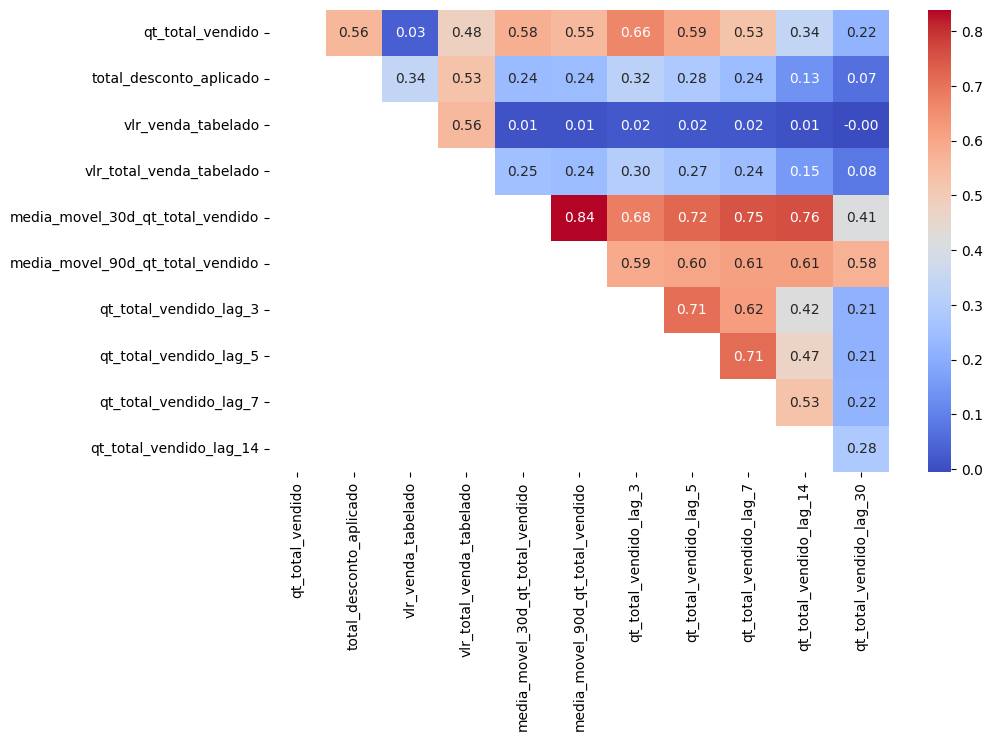

In [415]:
plt.figure(figsize = (10, 6))
mask = np.tril(np.ones_like(matriz_cor, dtype = bool))
sns.heatmap(matriz_cor, annot = True, fmt = '.2f', cmap = 'coolwarm', mask = mask)
plt.show()

In [416]:
df_vendas.head()

,dt_venda,key_loja,cod_produto,qt_total_vendido,total_desconto_aplicado,vlr_venda_tabelado,vlr_total_venda_tabelado,media_movel_30d_qt_total_vendido,media_movel_90d_qt_total_vendido,qt_total_vendido_lag_3,qt_total_vendido_lag_5,qt_total_vendido_lag_7,qt_total_vendido_lag_14,qt_total_vendido_lag_30
0,2024-01-02,5,29226,1,0.00,389.7,389.7,0.0,0.0,1.0,1.0,1.0,2.0,1.0
0,2024-01-02,5,1428,1,69.48,230.7,230.7,0.0,0.0,1.0,2.0,1.0,2.0,2.0
0,2024-01-02,2,48282,1,96.00,461.4,461.4,0.0,0.0,4.0,3.0,4.0,3.0,1.0
0,2024-01-02,8,52008,1,29.07,164.7,164.7,0.0,0.0,5.0,3.0,3.0,1.0,10.0
0,2024-01-02,1,48062,1,0.00,284.7,284.7,0.0,0.0,2.0,1.0,1.0,1.0,1.0


Separando X e y

In [417]:
X = df_vendas.drop(columns = ['dt_venda', 'key_loja', 'cod_produto','qt_total_vendido'])
y = df_vendas['qt_total_vendido']

In [418]:
valores_0 = df_vendas.query('qt_total_vendido == 0').qt_total_vendido.count()
total_base = df_vendas['qt_total_vendido'].count()

print(f'Total e linhas com valor 0: {valores_0}')
print(f'Total de linhas na base: {total_base}')
print(f'Precentual de 0 na base: {round((valores_0/total_base)*100,2)}%')

Total e linhas com valor 0: 0
Total de linhas na base: 55978
Precentual de 0 na base: 0.0%


Para melhor performance irei utilizar uma amostra de aproximadamento 10% da base total para treinar os modelos.

In [419]:
X_sample = X
y_sample = y

In [420]:
np.random.seed(123)
indices = np.random.choice(X.index, size = 1000, replace = False)
X_sample = X.iloc[indices]
y_sample = y.iloc[indices]

Criei um dicionário com os algoritmos a serem testados e aplicarei o Randomized Search para identificar os melhores hiperparâmetros de cada um.

In [421]:
# Lista de algoritmos e hiperparâmetros testados (altere os valores conforme a necessidade)
modelos = {
    'REGRESSÃO LINEAR': (LinearRegression(), {
        'fit_intercept': [True]
    }),
    'ÁRVORE DE REGRESSÃO': (DecisionTreeRegressor(), {
        'criterion': ['squared_error', 'absolute_error'],
        'min_samples_leaf': np.arange(20, 101),
        'max_depth': np.arange(2, 11)
    }),
    'FLORESTA ALEATÓRIA': (RandomForestRegressor(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'criterion': ['squared_error', 'absolute_error'],
        'min_samples_leaf': np.arange(20, 101),
        'max_depth': np.arange(2, 11)
    }),
    'ADABOOST': (AdaBoostRegressor(loss = 'square'), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.2, 0.01)
    }),
    'GRADIENT BOOSTING': (GradientBoostingRegressor(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.2, 0.01),
        'max_depth': np.arange(2, 11),
        'min_samples_leaf': np.arange(20, 101)
    }),
    'XGBOOST': (XGBRegressor(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.2, 0.01),
        'max_depth': np.arange(2, 11),
        'min_child_weight': np.arange(1, 11),
        'gamma': np.arange(0.5, 1.1, 0.1)
    }),
    'LIGHTGBM': (LGBMRegressor(verbose = -1, importance_type = 'gain', n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.2, 0.01),
        'max_depth': np.arange(2, 11),
        'min_data_in_leaf': np.arange(20, 101)
    })
}

Separando vairiáveis que irá capturar o melhor algorítimo, melhor modelo (hiperparâmetros) e melhor score

In [422]:
melhor_algoritmo = ""
melhor_modelo = None
melhor_score = float('-inf')

Separando as camadas interna e externa da validação cruzada aninhada

In [423]:
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [424]:
# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos.items():

  # Métricas de interesse
  scoring = {'neg_root_mean_squared_error': 'neg_root_mean_squared_error', 'neg_mean_absolute_error': 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error', 'r2': 'r2'}

  # grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'neg_root_mean_squared_error', n_jobs = -1)
  random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'neg_root_mean_squared_error', n_iter = 50, random_state = 123, n_jobs = -1)
  nested_scores = cross_validate(random_search, X = X_sample, y = y_sample, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_neg_root_mean_squared_error']) > melhor_score:
      melhor_algoritmo = nome
      melhor_modelo = random_search
      melhor_score = np.mean(nested_scores['test_neg_root_mean_squared_error'])

  # Resultados
  print(f'--- {nome} ---')
  print("Média de RMSE: " + str(-round(np.mean(nested_scores['test_neg_root_mean_squared_error']), 3)))
  print("D.P. de RMSE: " + str(round(np.std(nested_scores['test_neg_root_mean_squared_error']), 3)))
  print("Média de MAE: " + str(-round(np.mean(nested_scores['test_neg_mean_absolute_error']), 3)))
  print("D.P. de MAE: " + str(round(np.std(nested_scores['test_neg_mean_absolute_error']), 3)))
  print("Média de MAPE: " + str(-round(np.mean(nested_scores['test_neg_mean_absolute_percentage_error']), 3)))
  print("D.P. de MAPE: " + str(round(np.std(nested_scores['test_neg_mean_absolute_percentage_error']), 3)))
  print("Média de R^2: " + str(round(np.mean(nested_scores['test_r2']), 3)))
  print("D.P. de R^2: " + str(round(np.std(nested_scores['test_r2']), 3)))
  print("")

print(f"O melhor algoritmo é {melhor_algoritmo}, para os valores de hiperparâmetros testados.")

--- REGRESSÃO LINEAR ---
Média de RMSE: 1.201
D.P. de RMSE: 0.142
Média de MAE: 0.765
D.P. de MAE: 0.049
Média de MAPE: 0.405
D.P. de MAPE: 0.023
Média de R^2: 0.875
D.P. de R^2: 0.032

--- ÁRVORE DE REGRESSÃO ---
Média de RMSE: 1.781
D.P. de RMSE: 0.372
Média de MAE: 0.569
D.P. de MAE: 0.157
Média de MAPE: 0.125
D.P. de MAPE: 0.053
Média de R^2: 0.739
D.P. de R^2: 0.06

--- FLORESTA ALEATÓRIA ---
Média de RMSE: 1.746
D.P. de RMSE: 0.499
Média de MAE: 0.596
D.P. de MAE: 0.188
Média de MAPE: 0.177
D.P. de MAPE: 0.073
Média de R^2: 0.753
D.P. de R^2: 0.074

--- ADABOOST ---
Média de RMSE: 0.743
D.P. de RMSE: 0.067
Média de MAE: 0.579
D.P. de MAE: 0.038
Média de MAPE: 0.354
D.P. de MAPE: 0.045
Média de R^2: 0.951
D.P. de R^2: 0.016

--- GRADIENT BOOSTING ---
Média de RMSE: 0.407
D.P. de RMSE: 0.08
Média de MAE: 0.105
D.P. de MAE: 0.011
Média de MAPE: 0.044
D.P. de MAPE: 0.005
Média de R^2: 0.983
D.P. de R^2: 0.013

--- XGBOOST ---
Média de RMSE: 0.295
D.P. de RMSE: 0.06
Média de MAE: 0.13

Ajuste de modelo final na base de desenvolvimento, usando validação cruzada que será utilizado no random search

In [425]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)

In [426]:
scoring = {'neg_root_mean_squared_error': 'neg_root_mean_squared_error', 'neg_mean_absolute_error': 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error', 'r2': 'r2'}

definindo os melhores hiperparâmetros

In [427]:
modelo_final = RandomizedSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'neg_root_mean_squared_error', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final.fit(X_sample, y_sample)

print(f"Melhores hiperparâmetros para {melhor_algoritmo}: {modelo_final.best_params_}")

Melhores hiperparâmetros para XGBOOST: {'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.15000000000000002, 'gamma': 0.7}


### Explicabilidade

Aplicando shap para identificar a importância das variável no modelo e identificação da contribuição de cada uma delas na predição.

In [428]:
features_qualitativas = X_sample.select_dtypes(include = ['object', 'category']).columns
features_quantitativas = X_sample.select_dtypes(include = ['int64', 'float64']).columns
features = list(features_qualitativas) + list(features_quantitativas)

In [429]:
if melhor_algoritmo == 'ADABOOST':
  print("Cálculo de valores SHAP muito oneroso em modelos de projeção, usando AdaBost na biblioteca SHAP.")
else:
  explainer = shap.Explainer(modelo_final.best_estimator_)
  valores_shap = explainer(X_sample)

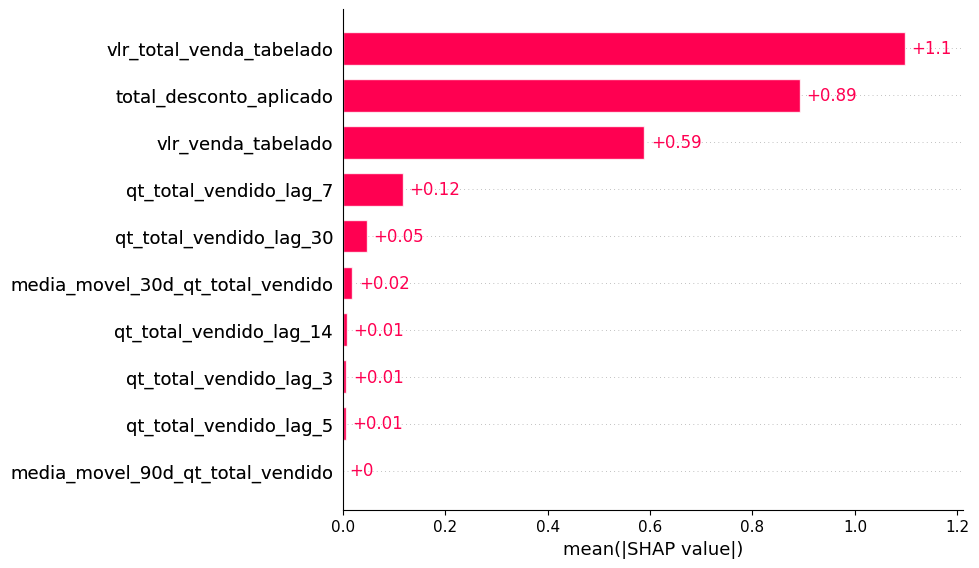

In [430]:
if melhor_algoritmo == 'ADABOOST':
  print("Cálculo de valores SHAP muito oneroso em modelos de projeção, usando AdaBost na biblioteca SHAP.")
else:
  shap.plots.bar(shap.Explanation(values = valores_shap, feature_names = features))

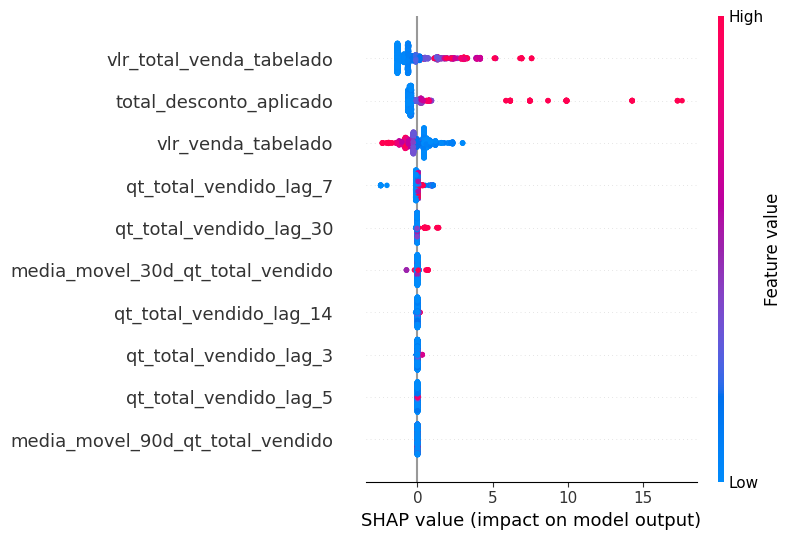

In [431]:
if melhor_algoritmo == 'ADABOOST':
  print("Cálculo de valores SHAP muito oneroso em modelos de projeção, usando AdaBost na biblioteca SHAP")
else:
  shap.summary_plot(shap.Explanation(values = valores_shap, feature_names = features))

O modelo será aplicado utilizando o segundo dado mais recente como base de entrada. Em seguida, será realizada a predição para o dado mais recente disponível. A comparação entre os valores previstos e os valores reais permitirá calcular métricas de desempenho como:

- MAE (Erro Absoluto Médio)
- RMSE (Raiz do Erro Quadrático Médio)
- MAPE (Erro Percentual Absoluto Médio)

In [432]:
df_predict_real = df_mais_recentes.drop(columns=['dt_venda','key_loja','cod_produto','qt_total_vendido'])
y_pred_real = modelo_final.best_estimator_.predict(df_predict_real)
df_mais_recentes['pred'] = y_pred_real
df_mais_recentes['pred'] = df_mais_recentes['pred'].round(0).astype(int)

In [433]:
df_mais_recentes

,dt_venda,key_loja,cod_produto,qt_total_vendido,total_desconto_aplicado,vlr_venda_tabelado,vlr_total_venda_tabelado,media_movel_30d_qt_total_vendido,media_movel_90d_qt_total_vendido,qt_total_vendido_lag_3,qt_total_vendido_lag_5,qt_total_vendido_lag_7,qt_total_vendido_lag_14,qt_total_vendido_lag_30,pred
42,2024-12-31,7,47905,1,846.00,2788.2,2788.2,1.428571,1.416667,1.0,1.0,3.0,1.0,4.0,3
19,2024-12-31,3,83068,1,129.00,509.7,509.7,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1
286,2024-12-31,5,48676,1,0.00,203.7,203.7,9.703704,5.753425,14.0,12.0,2.0,2.0,4.0,2
155,2024-12-31,7,48062,8,1740.00,599.4,4795.2,5.541667,5.253521,13.0,1.0,6.0,7.0,2.0,13
94,2024-12-31,5,49887,3,163.02,164.7,494.1,1.941176,2.024390,1.0,2.0,2.0,2.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,2024-01-23,5,48253,2,72.00,170.7,341.4,1.125000,1.125000,1.0,1.0,1.0,1.0,15.0,2
0,2024-01-12,2,75152,1,0.00,134.7,134.7,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,2
0,2024-01-09,3,47881,1,75.03,389.7,389.7,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1
3,2024-01-09,6,82037,4,0.00,224.7,898.8,2.000000,2.000000,2.0,1.0,1.0,1.0,2.0,3


In [434]:
df_vendas_ultima_test = df_vendas_agg.copy()
df_vendas_ultima_test = df_vendas_ultima_test.sort_values('dt_venda', ascending=False)

df_vendas_ultima_test = df_vendas_ultima_test.drop_duplicates(subset=['key_loja', 'cod_produto'], keep='first')

df_vendas_ultima_test = df_vendas_ultima_test[['key_loja','cod_produto','qt_total_vendido']]
df_vendas_ultima_test = df_vendas_ultima_test.rename(columns={'qt_total_vendido': 'qt_total_vendido_atual'})

df_vendas_ultima_test.head()

,key_loja,cod_produto,qt_total_vendido_atual
42,7,47905,1
152,2,74096,1
6,7,49890,1
161,8,48672,1
99,7,77684,4


In [435]:
df_recente_fim = df_mais_recentes.merge(df_vendas_ultima_test, on=['key_loja','cod_produto'], how='left')
df_recente_fim

,dt_venda,key_loja,cod_produto,qt_total_vendido,total_desconto_aplicado,vlr_venda_tabelado,vlr_total_venda_tabelado,media_movel_30d_qt_total_vendido,media_movel_90d_qt_total_vendido,qt_total_vendido_lag_3,qt_total_vendido_lag_5,qt_total_vendido_lag_7,qt_total_vendido_lag_14,qt_total_vendido_lag_30,pred,qt_total_vendido_atual
0,2024-12-31,7,47905,1,846.00,2788.2,2788.2,1.428571,1.416667,1.0,1.0,3.0,1.0,4.0,3,1
1,2024-12-31,3,83068,1,129.00,509.7,509.7,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1,1
2,2024-12-31,5,48676,1,0.00,203.7,203.7,9.703704,5.753425,14.0,12.0,2.0,2.0,4.0,2,1
3,2024-12-31,7,48062,8,1740.00,599.4,4795.2,5.541667,5.253521,13.0,1.0,6.0,7.0,2.0,13,8
4,2024-12-31,5,49887,3,163.02,164.7,494.1,1.941176,2.024390,1.0,2.0,2.0,2.0,1.0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,2024-01-23,5,48253,2,72.00,170.7,341.4,1.125000,1.125000,1.0,1.0,1.0,1.0,15.0,2,2
720,2024-01-12,2,75152,1,0.00,134.7,134.7,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,2,1
721,2024-01-09,3,47881,1,75.03,389.7,389.7,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1,1
722,2024-01-09,6,82037,4,0.00,224.7,898.8,2.000000,2.000000,2.0,1.0,1.0,1.0,2.0,3,4


Após o cálculo das métricas, é possível observar algumas diferenças entre o desempenho do modelo durante o treino e sua aplicação em dados reais. Essas variações são esperadas e ocorrem naturalmente, uma vez que o modelo tende a se ajustar melhor aos padrões presentes nos dados de treinamento. Já nos dados reais, especialmente em cenários com maior variabilidade ou eventos não observados previamente, o modelo pode apresentar uma queda de desempenho.

Essas diferenças reforçam a importância de uma validação robusta e da análise contínua do modelo em produção, garantindo que ele mantenha um bom nível de generalização e confiabilidade ao longo do tempo.

Como os dados de vendas tende a mudar rápidamente devido promoções ou comportamentos sazonais, recomendo um retreino quinzenal.

In [436]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(df_recente_fim['qt_total_vendido_atual'], df_recente_fim['pred'])
rmse = mean_squared_error(df_recente_fim['qt_total_vendido_atual'], df_recente_fim['pred'], squared=False)
mape = (abs((df_recente_fim['qt_total_vendido_atual'] - df_recente_fim['pred']) / df_recente_fim['qt_total_vendido_atual'])).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.2859
RMSE: 1.5319
MAPE: 11.91%


Neste processo, será simulada uma previsão de vendas nos casos em que houver ruptura de estoque. O orquestrador será responsável por acionar o modelo sempre que uma ruptura for detectada, utilizando como base a última referência de vendas do produto na respectiva loja. As features previamente criadas serão aplicadas a essa referência e servirão como entrada para o modelo preditivo.

In [437]:
df_vendas_ultima = df_vendas_agg.copy()
df_vendas_ultima = df_vendas_ultima.sort_values('dt_venda', ascending=False)

df_vendas_ultima = df_vendas_ultima.drop_duplicates(subset=['key_loja', 'cod_produto'], keep='first')

df_vendas_ultima.head()

,dt_venda,key_loja,cod_produto,qt_total_vendido,total_desconto_aplicado,vlr_venda_tabelado,vlr_total_venda_tabelado,media_movel_30d_qt_total_vendido,media_movel_90d_qt_total_vendido,qt_total_vendido_lag_3,qt_total_vendido_lag_5,qt_total_vendido_lag_7,qt_total_vendido_lag_14,qt_total_vendido_lag_30,rank
42,2024-12-31,7,47905,1,846.00,2788.2,2788.2,1.428571,1.416667,1.0,1.0,3.0,1.0,4.0,1.0
152,2024-12-31,2,74096,1,0.00,524.7,524.7,1.916667,2.105263,2.0,1.0,2.0,1.0,3.0,1.0
6,2024-12-31,7,49890,1,35.22,149.7,149.7,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
161,2024-12-31,8,48672,1,0.00,194.7,194.7,2.090909,2.076923,1.0,3.0,1.0,3.0,2.0,1.0
99,2024-12-31,7,77684,4,945.00,5036.4,20145.6,2.000000,1.982456,2.0,1.0,4.0,4.0,1.0,1.0


In [438]:
df_estoques_ruptura = df_estoques.copy()
df_estoques_ruptura = df_estoques_ruptura[df_estoques_ruptura['ruptura'] == 1]

df_estoques_ruptura = df_estoques_ruptura.sort_values('dt_estoque', ascending=False)

df_estoques_ruptura = df_estoques_ruptura.drop_duplicates(subset=['key_loja', 'cod_produto'], keep='first')

df_estoques_ruptura.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,ruptura
260838,8,85124,2024-12-31,0,1
71380,3,25472,2024-12-31,0,1
94930,3,74722,2024-12-31,0,1
204425,6,77989,2024-12-31,0,1
123652,4,49898,2024-12-31,0,1


In [439]:
df_vendas_final = df_vendas_ultima.merge(df_estoques_ruptura, on=['key_loja','cod_produto'], how='left')
df_vendas_final = df_vendas_final.rename(columns={'dt_estoque': 'dt_previsao'})

df_vendas_final

,dt_venda,key_loja,cod_produto,qt_total_vendido,total_desconto_aplicado,vlr_venda_tabelado,vlr_total_venda_tabelado,media_movel_30d_qt_total_vendido,media_movel_90d_qt_total_vendido,qt_total_vendido_lag_3,qt_total_vendido_lag_5,qt_total_vendido_lag_7,qt_total_vendido_lag_14,qt_total_vendido_lag_30,rank,dt_previsao,qt_estoque,ruptura
0,2024-12-31,7,47905,1,846.00,2788.2,2788.2,1.428571,1.416667,1.0,1.0,3.0,1.0,4.0,1.0,2024-06-05,0.0,1.0
1,2024-12-31,2,74096,1,0.00,524.7,524.7,1.916667,2.105263,2.0,1.0,2.0,1.0,3.0,1.0,2024-03-19,0.0,1.0
2,2024-12-31,7,49890,1,35.22,149.7,149.7,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,2024-11-06,0.0,1.0
3,2024-12-31,8,48672,1,0.00,194.7,194.7,2.090909,2.076923,1.0,3.0,1.0,3.0,2.0,1.0,2024-12-19,0.0,1.0
4,2024-12-31,7,77684,4,945.00,5036.4,20145.6,2.000000,1.982456,2.0,1.0,4.0,4.0,1.0,1.0,2024-06-05,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,2024-01-23,5,48253,2,72.00,170.7,341.4,1.125000,1.125000,1.0,1.0,1.0,1.0,15.0,1.0,2024-12-31,0.0,1.0
720,2024-01-12,2,75152,1,0.00,134.7,134.7,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,2024-12-31,0.0,1.0
721,2024-01-09,3,47881,1,75.03,389.7,389.7,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,2024-09-14,0.0,1.0
722,2024-01-09,6,82037,4,0.00,224.7,898.8,2.000000,2.000000,2.0,1.0,1.0,1.0,2.0,1.0,2024-12-31,0.0,1.0


In [440]:
df_predict = df_vendas_ultima.drop(columns=['dt_venda','key_loja','cod_produto','qt_total_vendido','rank'])

In [441]:
y_pred = modelo_final.best_estimator_.predict(df_predict)

In [442]:
df_vendas_final['pred'] = y_pred

In [443]:
df_vendas_final['pred'] = df_vendas_final['pred'].round(0)
df_vendas_final['media_movel_30d_qt_total_vendido'] = df_vendas_final['media_movel_30d_qt_total_vendido'].round(0)
df_vendas_final['media_movel_90d_qt_total_vendido'] = df_vendas_final['media_movel_90d_qt_total_vendido'].round(0)
df_vendas_final

,dt_venda,key_loja,cod_produto,qt_total_vendido,total_desconto_aplicado,vlr_venda_tabelado,vlr_total_venda_tabelado,media_movel_30d_qt_total_vendido,media_movel_90d_qt_total_vendido,qt_total_vendido_lag_3,qt_total_vendido_lag_5,qt_total_vendido_lag_7,qt_total_vendido_lag_14,qt_total_vendido_lag_30,rank,dt_previsao,qt_estoque,ruptura,pred
0,2024-12-31,7,47905,1,846.00,2788.2,2788.2,1.0,1.0,1.0,1.0,3.0,1.0,4.0,1.0,2024-06-05,0.0,1.0,3.0
1,2024-12-31,2,74096,1,0.00,524.7,524.7,2.0,2.0,2.0,1.0,2.0,1.0,3.0,1.0,2024-03-19,0.0,1.0,1.0
2,2024-12-31,7,49890,1,35.22,149.7,149.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2024-11-06,0.0,1.0,1.0
3,2024-12-31,8,48672,1,0.00,194.7,194.7,2.0,2.0,1.0,3.0,1.0,3.0,2.0,1.0,2024-12-19,0.0,1.0,1.0
4,2024-12-31,7,77684,4,945.00,5036.4,20145.6,2.0,2.0,2.0,1.0,4.0,4.0,1.0,1.0,2024-06-05,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,2024-01-23,5,48253,2,72.00,170.7,341.4,1.0,1.0,1.0,1.0,1.0,1.0,15.0,1.0,2024-12-31,0.0,1.0,2.0
720,2024-01-12,2,75152,1,0.00,134.7,134.7,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2024-12-31,0.0,1.0,2.0
721,2024-01-09,3,47881,1,75.03,389.7,389.7,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2024-09-14,0.0,1.0,1.0
722,2024-01-09,6,82037,4,0.00,224.7,898.8,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2024-12-31,0.0,1.0,3.0


In [444]:
df_vendas_final_test = df_vendas_final[(df_vendas_final['cod_produto']==1428) & (df_vendas_final['key_loja']==1)]
df_vendas_final_test

,dt_venda,key_loja,cod_produto,qt_total_vendido,total_desconto_aplicado,vlr_venda_tabelado,vlr_total_venda_tabelado,media_movel_30d_qt_total_vendido,media_movel_90d_qt_total_vendido,qt_total_vendido_lag_3,qt_total_vendido_lag_5,qt_total_vendido_lag_7,qt_total_vendido_lag_14,qt_total_vendido_lag_30,rank,dt_previsao,qt_estoque,ruptura,pred
379,2024-12-19,1,1428,1,0.0,248.7,248.7,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2024-11-22,0.0,1.0,1.0
